# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 3: Base Line Modelo Predictivo

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelo Predictivo

## Introducción: 

En esta fase del proyecto se desarrollará el proceso de modelado predictivo enfocado en estimar los valores de actividad biológica de péptidos (Concentración Efectiva 50 - EC50_T2) a partir de un conjunto de descriptores moleculares obtenidos en la etapa de ingeniería de características. Dado que la variable objetivo (EC50_T2) corresponde a un valor continuo, se implementará un modelo de regresión supervisada dentro de un entorno automatizado de aprendizaje de máquina (Pipeline con AutoML y Blend Models ). Este enfoque permitirá ejecutar múltiples algoritmos, optimizar sus hiperparámetros y comparar su desempeño mediante métricas estandarizadas, garantizando la selección del modelo más eficiente y generalizable (Géron, 2022).

Para establecer una línea base , se emplean algoritmos de regresión ampliamente reconocidos por su estabilidad y capacidad de interpretar relaciones no lineales entre las variables de entrada y la variable objetivo. Entre ellos destacan el Extra Trees Regressor, el Regresor Lineal y el Random Forest Regressor, los cuales permitirán obtener un punto de referencia del rendimiento predictivo inicial. En particular, el Extra Trees Regressor resulta apropiado para este tipo de datos, pues combina una alta capacidad de generalización con un bajo costo computacional y ofrece una evaluación directa de la importancia de las características, facilitando la depuración de descriptores irrelevantes que podrían afectar la precisión del modelo (Pedregosa et al., 2011).

Dado el carácter continuo de la variable EC50_T2, las métricas más adecuadas para evaluar el desempeño del modelo son el Error Absoluto Medio (MAE), el Error Cuadrático Medio (MSE), la Raíz del Error Cuadrático Medio (RMSE) y el Coeficiente de Determinación (R²). Estas medidas permitirán  cuantificar la diferencia entre los valores predichos y los observados, siendo el MAE y el RMSE particularmente útiles para interpretar el error promedio en unidades comparables con la variable objetivo. En el contexto del proyecto, de acuerdo con nuestros asesores se considera que un valor de R² superior a 0.6 y un RMSE menor a 0.80 representan un desempeño mínimo aceptable, ya que reflejan una capacidad predictiva sólida y un margen de error moderado en relación con la escala de los datos (Han, Kamber & Pei, 2022). Este nivel de precisión permitirá que el modelo sea confiable como herramienta de apoyo en la identificación de nuevos péptidos con potencial actividad biológica.

### Carga de los datos procesados

In [ ]:
# Carga de archivos y librerias basicas

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import sys
import os
import pycaret
from pycaret.regression import *
from pycaret.utils import *

# Rutas locales a Bibliotecas y utilerias
from pathlib import Path

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()

# Subir un nivel para llegar a la carpeta raíz del proyecto
project_root = notebook_dir.parent

# Añadir la carpeta raíz al path de Python
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Ruta del proyecto añadida al path: {project_root}")

from src.plotting import plot_pca_3d

Ruta del proyecto añadida al path: d:\source\Proyecto Integrador\glp-1_drug_discovery


In [ ]:
# Establecer la ruta los archivos de datos
directorio_base = Path("../")
directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

# --- Rutas de Archivos de Datos ---
# Datos con actividad conocida (para entrenamiento)
ruta_125_ec50 = processed_data_dir / "descriptores_125.csv"

# Datos sin actividad conocida (para predicción)
ruta_peptidos_eval = processed_data_dir / "descriptores_cdhit.csv"


# Ruta archivo con péptidos con actividad EC50 filtrado con 20 descriptores de entropia
ruta_125_ent= processed_data_dir / "descriptores_Spearman.csv"

# --- Rutas para Modelos SIN PCA ---
ruta_dir_modelos = directorio_modelos_automl / "modelos_GLP1_no_pca"
ruta_top_modelos = ruta_dir_modelos / "top_modelos_GLP1"
ruta_modelo_stack = ruta_dir_modelos / "modelo_GLP1_stack"
ruta_modelo_blend = ruta_dir_modelos / "modelo_GLP1_blend"
ruta_pipeline = ruta_dir_modelos / "pipeline_modelo_GLP1"
ruta_mejor_modelo = ruta_dir_modelos / "mejor_modelo"
ruta_mejor_modelo_final = ruta_dir_modelos / "mejor_modelo_final"
ruta_experimento = ruta_dir_modelos / "experimento_GLP1"
ruta_resultados_prediccion = directorio_datos / "Predicciones_Peptidos_GLP1.csv"


os.makedirs(ruta_dir_modelos, exist_ok=True)

In [ ]:
# Carga de datos para predicción
df_entrenamiento = pd.read_csv(ruta_125_ec50)
df_entrenamiento.set_index('ID', inplace=True)
df_entrenamiento.columns = df_entrenamiento.columns.str.replace('.', '_', regex=False)

df_Entropia = pd.read_csv(ruta_125_ent)
df_Entropia.set_index('ID', inplace=True)
df_Entropia.columns = df_Entropia.columns.str.replace('.', '_', regex=False)

df_desconocidos = pd.read_csv(ruta_peptidos_eval)
df_desconocidos.set_index('ID', inplace=True)
df_desconocidos.columns = df_desconocidos.columns.str.replace('.', '_', regex=False)

### Calculo de pEC50 como columna objetivo

A fin de facilitar la interpretación de los resultados, se transforma la variable objetivo EC50 a pEC50, que es su logaritmo negativo en base 10. Esto convierte valores pequeños de EC50 (alta potencia) en valores grandes de pEC50 facilitando la comparación y análisis (GraphPad, s. f.; Srinivasan, 2025). El pEC50 es ampliamente usado en farmacología para representar la potencia de los compuestos de forma más intuitiva (GraphPad, s. f.).

Esto es especialmente útil en bioquímica y farmacología, donde se trabaja con rangos amplios de concentraciones; además, los valores de pEC₅₀ tienden a tener una distribución más “normalizada”, lo que mejora el desempeño de modelos predictivos y permite capturar más fácilmente las relaciones no lineales (Srinivasan, 2025; Motulsky, 2025). 
Trabajar directamente con EC50 puede ser problemático debido a su amplia gama y distribución sesgada, mientras que pEC50 tiende a comportarse mejor como variable dependiente en modelos de aprendizaje automático (van Tilborg et al., 2022).


In [ ]:
# Transformación de EC50_T2 a pEC50 positivo como columna objetivo
df_entrenamiento['pEC50'] = -np.log10(df_entrenamiento["EC50_T2"] * 1e-12)

In [ ]:
print("Datos de entrenamiento cargados y procesados:")
display(df_entrenamiento.tail(3))

Datos de entrenamiento cargados y procesados:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,NMBroto_BEGF750103_lag1,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,EC50_T2,EC50_LOG_T2,pEC50
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep123,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,0.066667,...,-0.086719,-0.055735,-0.043630,0.244102,-0.065565,-0.077700,HGEGTFTSDVSSYMEPQSTDEFIAWLLKGR,29500.0,-7.53,7.530178
seq_pep124,0.033333,0.0,0.066667,0.066667,0.100000,0.100000,0.033333,0.000000,0.033333,0.133333,...,-0.036403,0.038506,0.212170,0.105167,-0.015330,0.009052,HGEGTFTSDVSSYMDFQSLVEFLAWLLKGR,598.0,-9.22,9.223299
seq_pep125,0.000000,0.0,0.103448,0.103448,0.103448,0.103448,0.034483,0.000000,0.034483,0.172414,...,0.022766,0.121044,0.251192,-0.080384,0.006977,-0.121789,HGEGTFTSDLSKQMDFESLVLFLEWLDNG,30200.0,-7.52,7.519993


In [ ]:
print("\nDatos para predicción cargados:")
display(df_desconocidos.tail(3))


Datos para predicción cargados:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,NMBroto_BEGF750102_lag1,NMBroto_BEGF750102_lag2,NMBroto_BEGF750102_lag3,NMBroto_BEGF750103_lag1,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence
ID,,,,,,,,,,,,,,,,,,,,,
XP_029460758.1,0.100000,0.0,0.033333,0.166667,0.033333,0.100000,0.033333,0.033333,0.066667,0.066667,...,0.011346,-0.475407,-0.024437,0.068360,-0.398996,0.183171,0.280938,-0.224590,-0.040156,HAEGTYTSDISSYLEGEAAKKFVEWLVNGE
XP_030211526.1,0.166667,0.0,0.100000,0.066667,0.066667,0.066667,0.033333,0.000000,0.066667,0.066667,...,0.138736,-0.351684,-0.065743,0.188625,0.102809,0.159504,0.288551,-0.163517,-0.208109,HADGTYTSDVSAFLEEQAAKDFVAWLKNGQ
XP_031714513.1,0.066667,0.0,0.100000,0.033333,0.033333,0.066667,0.033333,0.000000,0.066667,0.066667,...,-0.026494,-0.553853,0.171746,0.109164,-0.175120,0.131347,0.177038,-0.277718,0.041709,HADGTYTSDVSSYLQDQAVKEFVSWLKNGR


Text(0.5, 1.0, 'Distribución de pEC50')

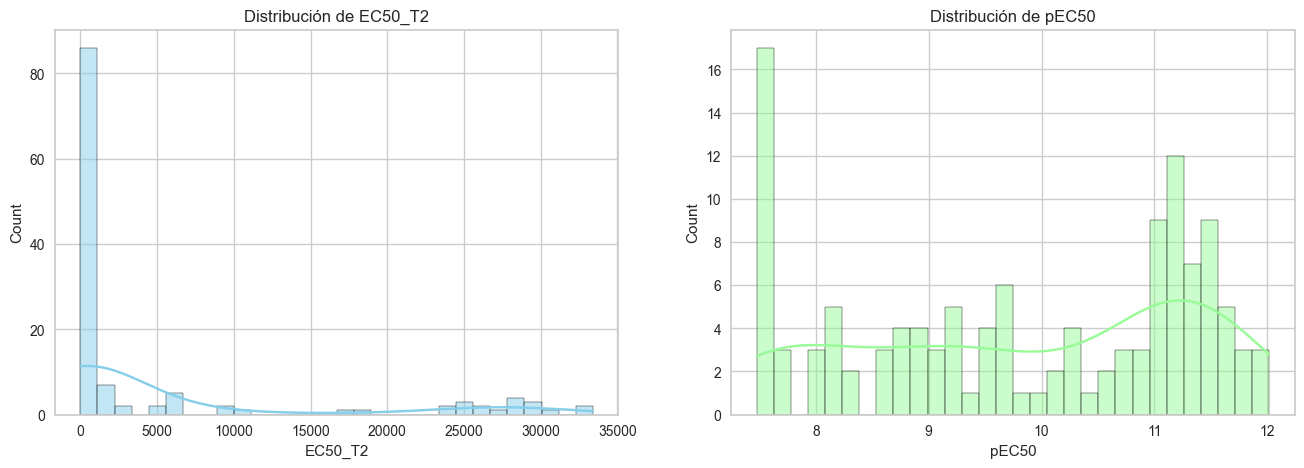

In [ ]:
## Grafico de la distribucion de ec50 y pEC50
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 2,  figsize=(16, 5))
sns.histplot(df_entrenamiento['EC50_T2'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribución de EC50_T2')
sns.histplot(df_entrenamiento['pEC50'], bins=30, kde=True, ax=ax[1], color='palegreen')
ax[1].set_title('Distribución de pEC50') 


### Ajuste de la Columna objetivo

El primer gráfico muestra la distribución de los valores de EC50_T2. Se puede observar claramente un fuerte sesgo positivo, con la gran mayoría de los datos concentrados en valores bajos y una cola larga hacia la derecha. Este tipo de distribución puede ser problemático para muchos algoritmos de machine learning, que a menudo funcionan mejor con variables objetivo que se aproximan a una distribución normal, en algunos casos tambien resulta problemático trabajar con valores negativos para la variable objetivo.

Para corregir este sesgo, aplicamos una transformación logarítmica negativa para convertir EC50_T2 en pEC50 $$(pEC50 = -log10(EC50))$$ 

Tras aplicar la transformación logarítmica la distribución a es mucho más simétrica y se asemeja más a una distribución normal (o bimodal), lo que la convierte en una variable objetivo mucho más adecuada para el entrenamiento de nuestros modelos de regresión.

## Experimento con todas las características obtenidas de los péptidos

En esta libreta se configura y ejecuta un experimento de regresión utilizando PyCaret AutoML para predecir la actividad biológica (pEC50) de péptidos basándose en sus descriptores moleculares.

En este experimento no se aplicó reducción de dimensionalidad (PCA) y se utilizaron todas las características disponibles junto con cross-validation usando 10 K-Folds.
La biblioteca PyCaret  Auto-sklearn ya incluyen internamente pasos de preprocesamiento, entre ellos:
* Normalización y escalado de variables.
* Codificación de variables categóricas.
* Selección automática de características (por correlación, importancia del modelo o métodos de reducción como PCA).
* Eliminación de variables constantes o con alta multicolinealidad.

Después de ejecutar varias pruebas previas se encontró que esta combinación de parámetros proporcionó buenos resultados, los parámetros clave de esta configuración son:
* ```Target='pEC50'```: Se define la columna pEC50 como nuestra variable objetivo a predecir.
* ```ignore_features``` Se excluyen las columnas EC50_T2 y EC50_LOG_T2 para que no sean consideradas como características predictivas.
* ```normalize=True``` Se activa la normalización de todas las características numéricas para escalarlas a un rango común, utilizando el método ```maxabs```.
* ```fold=10``` Se establece una estrategia de validación cruzada de 10 pliegues (K-folds), que es el método estándar para evaluar el rendimiento de los modelos.
* ```ignore_features```: Se excluyen las columnas EC50_T2 y EC50_LOG_T2 para que no sean consideradas como características predictivas.
* ```normalize=True```: Se activa la normalización de todas las características numéricas para escalarlas a un rango común, utilizando el método ```maxabs```.
* ```fold=10``` Se establece una estrategia de validación cruzada de 10 pliegues (K-folds), que es el método estándar para evaluar el rendimiento de los modelos.

Para este experimento no se aplicó reducción de dimensionalidad debido a que el desempeño de experimentos anteriores donde se aplicó PCA y reducción de dimensionalidad basada en entropía no lograron resultados aceptables debido al tamaño reducido del conjunto de entrenamiento de 125 peptídos

Por default PyCaret selecciona 70% de los datos para entrenamiento y el resto para validación


In [ ]:
# Parámetros globales para PyCaret
ignore_features = ['ID', 'EC50_T2', 'EC50_LOG_T2','sequence']
target = 'pEC50'

# Setup sin PCA
experiment = setup(
    data=df_entrenamiento, 
    target='pEC50',                 # columna objetivo
    ignore_features=ignore_features,
    normalize=True,   
    normalize_method='maxabs', 
    session_id=132400,              # simiar al random_state, permite reproducibilidad
    verbose=False,
    experiment_name='GLP1_NO_PCA',
    fold=10,                        # número de folds para cross-validation
    #use_gpu = True
)

### Entrenamiento y Selección de los Mejores Modelos
Entrenamos y evaluamos una grupo de modelos de regresión para establecer una línea "base" de rendimiento. Seleccionamos los 3 mejores modelos basados en su $R²$.
ademas se calcularon metricas adicionales como RMSE, MAE, MAPE y RMSLE para tener una visión más completa del rendimiento de los modelos (Chai, T., & Draxler, R. R. 2014).

PyCaret proporciona una variedad de métricas para evaluar el rendimiento de los modelos de regresión. A continuación, se describen las métricas utilizadas en este experimento (PyCaret. s. f.):

### Descripción de las métricas
#### Métricas Basadas en Error

Las siguientes métricas miden el error de un modelo; por lo tanto, **un valor más bajo siempre es mejor**. Generalmente, se expresan en la misma unidad que la variable objetivo (a excepción de MAPE).

---

#### MAE (Mean Absolute Error - Error Absoluto Medio)

El **MAE** calcula el promedio de las diferencias absolutas entre los valores reales ($y_i$) y los predichos ($\hat{y}_i$). Mide la magnitud promedio de los errores, sin considerar si son positivos o negativos. Es menos sensible a los valores atípicos (outliers) que el MSE.

* **Significado**: Un MAE de 5 indica que, en promedio, las predicciones del modelo se desvían 5 unidades del valor real.
* **Fórmula**:
    $MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

---

#### MSE (Mean Squared Error - Error Cuadrático Medio)

El **MSE** calcula el promedio de los errores al cuadrado. Al elevar el error al cuadrado, penaliza más fuertemente los errores grandes. Esto lo hace muy sensible a los outliers.

* **Significado**: Es más difícil de interpretar directamente, ya que las unidades están al cuadrado. Se usa principalmente como función de coste durante el entrenamiento del modelo.
* **Fórmula**:
    $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

---

#### RMSE (Root Mean Squared Error - Raíz del Error Cuadrático Medio)

El **RMSE** es  la raíz cuadrada del MSE. Su principal ventaja es que devuelve el error a las unidades originales de la variable objetivo, lo que lo hace mucho más fácil de interpretar que el MSE. Al igual que el MSE, penaliza más los errores grandes.

* **Significado**: Un RMSE de 7.5 significa que, en promedio, el modelo se equivoca en 7.5 unidades. Es una de las métricas más populares para evaluar modelos de regresión.
* **Fórmula**:
    $RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

---

#### RMSLE (Root Mean Squared Logarithmic Error - Raíz del Error Logarítmico Cuadrático Medio)

El **RMSLE** calcula el RMSE sobre el logaritmo de los valores predichos y reales. Es útil cuando no se desea penalizar tanto la diferencia entre valores grandes, sino más bien la relación porcentual. Solo se puede usar si los valores son positivos.

* **Significado**: Mide el error relativo. Por ejemplo, un error de predecir 110 cuando el valor real es 100 se considerará similar a un error de predecir 1100 cuando el valor es 1000. Es robusto frente a outliers.
* **Fórmula**:
    $RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}$

---

#### MAPE (Mean Absolute Percentage Error - Error Porcentual Absoluto Medio)

El **MAPE** expresa el error como un porcentaje promedio del valor real. Esto lo hace muy intuitivo y fácil de comunicar a audiencias no técnicas. Sin embargo, tiene un gran inconveniente: no se puede usar si los valores reales ($y_i$) son cero.

* **Significado**: Un MAPE del 15% significa que, en promedio, el error de predicción es del 15% del valor real.
* **Fórmula**:
    $MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$

---

### Métrica de Rendimiento

A diferencia de las anteriores, para esta métrica **un valor más alto es mejor**.

#### R² (Coeficiente de Determinación)

**R²**, o R-cuadrado, mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. En otras palabras, indica qué tan bien se ajusta el modelo a los datos.

* **Significado**: Su valor va de 0 a 1. Un **R² de 0.85** significa que el modelo es capaz de explicar el **85% de la variabilidad** de los datos. Un valor cercano a 1 indica un buen ajuste, mientras que un valor cercano a 0 indica que el modelo no es mejor que simplemente predecir el promedio de los datos.
* **Fórmula**:
    $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
    donde $\bar{y}$ es la media de los valores reales.

---




In [ ]:
# Obtener los 3 mejores modelos Basado en R² como métrica principal
# se seleccionan 3 modelos para un posterior tuning y blending/stacking

print("Comparando modelos para seleccionar los 3 mejores...")
best_3_models = experiment.compare_models(sort='R2', n_select=3)

Comparando modelos para seleccionar los 3 mejores...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.6644,0.8155,0.8531,0.6251,0.0820,0.0725,7.2990
et,Extra Trees Regressor,0.6770,0.8938,0.8819,0.5777,0.0844,0.0735,0.2330
huber,Huber Regressor,0.7284,0.9375,0.8747,0.5526,0.0846,0.0794,0.0800
ridge,Ridge Regression,0.7427,0.9430,0.8845,0.5465,0.0860,0.0810,0.0710
par,Passive Aggressive Regressor,0.7772,0.9966,0.9129,0.5282,0.0870,0.0838,0.0750
rf,Random Forest Regressor,0.7804,1.0125,0.9598,0.5259,0.0917,0.0845,0.3190
br,Bayesian Ridge,0.7770,0.9999,0.9194,0.5218,0.0892,0.0846,0.0800
lightgbm,Light Gradient Boosting Machine,0.7424,1.0383,0.9687,0.5195,0.0924,0.0807,0.1340
gbr,Gradient Boosting Regressor,0.7351,1.0012,0.9632,0.5186,0.0923,0.0795,0.2420
lr,Linear Regression,0.7658,1.0153,0.9249,0.5124,0.0906,0.0836,0.5680


### Análisis de los Mejores Modelos

Al analizar los resultados, se observa que: los modelos basados en ensambles de árboles de decisión son los que obtienen el mejor rendimiento.

Modelos Lineales Simples: Modelos como Lasso (lasso), Elastic Net (en) y Lasso Least Angle Regression (llar) obtuvieron un R² negativo (-0.1500), idéntico al del Dummy Regressor. Un R² negativo significa que el modelo es peor que simplemente predecir el valor promedio de la variable objetivo. Esto indica que estos modelos lineales no lograron capturar la complejidad de las relaciones en los datos.


In [ ]:
# Guardar el pipeline del experimento (usando el mejor modelo como referencia)
save_info = experiment.save_model(best_3_models, ruta_pipeline)
if save_info is not None:
    print(f"Modelo guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el modelo.")

print("\nLos 3 mejores modelos son:")
print(best_3_models)

Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_no_pca\pipeline_modelo_GLP1.pkl

Los 3 mejores modelos son:
[<catboost.core.CatBoostRegressor object at 0x0000022AC81BEEA0>, ExtraTreesRegressor(n_jobs=-1, random_state=132400), HuberRegressor()]


### Ajuste Fino (Tuning) de Hiperparámetros
Una vez comparados los modelos se seleccionó a los 3 mejores modelos para optimizar los hiperparámetros a fin de intentar mejorar la capacidad predictiva.
En caso de no encontrar mejoras tras el ajuste de hiperparámetros, se empleará el modelo sin ajustar obtenido previamente


**Nota sobre las métricas:**
Los resultados siguientes indican el desempeño del modelo por cada K-fold, se resalta en amarillo la media de las métricas obtenidas en cross-validation.


In [ ]:
# Afinar los mejores modelos sin PCA y guardarlos individualmente
from ray.tune.search.hyperopt import HyperOptSearch

print("----- Ajuste de modelos -----")

# Ajustar los 3 mejores modelos con 50 iteraciones
print("\nAjustando los 3 mejores modelos...")
tuned_best_3 = [experiment.tune_model(model,
                                         n_iter=10,
                                         optimize='R2',
                                         fold=10,
                                         search_library='scikit-optimize',
                                         search_algorithm='bayesian', 
                                         early_stopping=True) for model in best_3_models]

# Guardar los modelos ajustados
print("\nGuardando modelos ajustados...")
for i, model in enumerate(tuned_best_3):
    save_info = experiment.save_model(model, f"{ruta_top_modelos}_{i+1}")
    if save_info is not None:
        print(f"Modelo guardado en: {save_info[1]}")
    else:
        print("No se pudo guardar el modelo.")

----- Ajuste de modelos -----

Ajustando los 3 mejores modelos...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8939,1.3303,1.1534,0.4731,0.1134,0.1012
1,0.7398,0.8204,0.9058,0.7344,0.0806,0.0721
2,0.4289,0.3013,0.5489,0.7821,0.0534,0.0455
3,0.5881,0.5580,0.7470,0.7943,0.0772,0.0692
4,1.1939,2.7227,1.6501,-0.1613,0.1607,0.1419
5,0.4797,0.3852,0.6206,0.7724,0.0571,0.0482
6,0.4651,0.4653,0.6822,0.6971,0.0643,0.0475
7,0.4955,0.3817,0.6178,0.8120,0.0589,0.0546
8,0.6054,0.4598,0.6781,0.6848,0.0630,0.0619


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9248,1.4457,1.2024,0.4274,0.1178,0.1047
1,0.8371,1.1234,1.0599,0.6362,0.0952,0.0817
2,0.4965,0.3687,0.6072,0.7334,0.0582,0.0544
3,0.6426,0.8040,0.8966,0.7037,0.0911,0.0761
4,1.3459,2.8388,1.6849,-0.2108,0.1633,0.1561
5,0.3945,0.2252,0.4745,0.8669,0.0446,0.0399
6,0.5781,0.7374,0.8587,0.5200,0.0781,0.0554
7,0.4055,0.2599,0.5098,0.8720,0.0515,0.0461
8,0.7411,0.8180,0.9044,0.4393,0.0834,0.0745


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9304,1.6202,1.2729,0.3583,0.1313,0.1135
1,0.5769,0.5629,0.7503,0.8177,0.0670,0.0566
2,0.6616,0.5977,0.7731,0.5678,0.0796,0.0719
3,0.4326,0.2368,0.4866,0.9127,0.0440,0.0445
4,1.6486,3.6572,1.9124,-0.5599,0.1847,0.1884
5,0.3522,0.1705,0.4129,0.8992,0.0370,0.0351
6,0.6114,0.5373,0.7330,0.6503,0.0659,0.0592
7,0.7490,0.7751,0.8804,0.6183,0.0886,0.0868
8,0.7839,0.8228,0.9071,0.4360,0.0846,0.0778


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Guardando modelos ajustados...
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_no_pca\top_modelos_GLP1_1.pkl
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_no_pca\top_modelos_GLP1_2.pkl
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret

### Creación de Ensambles: Stacking y Blending
Una vez ajustados los mejores modelos se realiza una “Ensable” que consiste en combinar múltiples modelos para mejorar la precisión y robustez de las predicciones. 
El “ensemble stacking” entrena un meta-modelo sobre las predicciones de varios modelos base, mientras que el “ensemble blending model” promedia las predicciones de los modelos base para obtener una predicción final.
Para este experimento combinamos los modelos ajustados utilizando Stacking y Blending, para crear meta-modelos potencialmente más robustos usando los  mejores modelos ajustados previamente.


In [ ]:
# Crear un modelo de apilamiento (Stacking)
print("\nCreando el modelo Stacking...")
stacked_model = experiment.stack_models(estimator_list=tuned_best_3)

# Crear un modelo de mezcla (Blending)
print("\nCreando el modelo Blending...")
blended_model = experiment.blend_models(estimator_list=tuned_best_3)



Creando el modelo Stacking...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7611,1.1481,1.0715,0.5452,0.1088,0.0908
1,0.7258,0.8907,0.9438,0.7116,0.0830,0.0696
2,0.5064,0.4390,0.6626,0.6826,0.0657,0.0536
3,0.3878,0.1939,0.4404,0.9285,0.0427,0.0422
4,1.5242,3.3369,1.8267,-0.4233,0.1764,0.1753
5,0.3963,0.2620,0.5118,0.8452,0.0468,0.0400
6,0.5219,0.4726,0.6874,0.6924,0.0637,0.0524
7,0.5425,0.4480,0.6693,0.7794,0.0644,0.0601
8,0.6444,0.5938,0.7706,0.5930,0.0716,0.0645



Creando el modelo Blending...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7875,1.2443,1.1155,0.5072,0.1124,0.0936
1,0.6937,0.7785,0.8823,0.7479,0.0785,0.0676
2,0.4193,0.2969,0.5449,0.7853,0.0512,0.0438
3,0.5184,0.4048,0.6362,0.8508,0.0648,0.0596
4,1.3585,2.9553,1.7191,-0.2605,0.1666,0.1585
5,0.3447,0.1914,0.4375,0.8869,0.0400,0.0348
6,0.5409,0.5084,0.7130,0.6691,0.0650,0.0531
7,0.4712,0.3907,0.6251,0.8076,0.0610,0.0522
8,0.6652,0.6470,0.8044,0.5565,0.0747,0.0674


## Búsqueda Automática del Mejor Modelo (AutoML)
Dejamos a PyCaret la tarea de encontrar el mejor modelo posible de manera automática, considerando todos los modelos y ensambles disponibles.

In [ ]:
# Ejecutar automl para encontrar el mejor modelo general, optimizando por R2
best_model_automl = experiment.automl(optimize='R2')
print("\nMejor modelo encontrado por AutoML:")
print(best_model_automl.score)


Mejor modelo encontrado por AutoML:
<bound method RegressorMixin.score of VotingRegressor(estimators=[('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x0000022AD0F52180>),
                            ('Extra Trees Regressor',
                             ExtraTreesRegressor(criterion='absolute_error',
                                                 max_depth=5,
                                                 max_features=0.567711756337121,
                                                 min_impurity_decrease=0.005297055476899181,
                                                 min_samples_leaf=2,
                                                 n_estimators=155, n_jobs=-1,
                                                 random_state=132400)),
                            ('Huber Regressor',
                             HuberRegressor(alpha=0.987530237988201,
                                            epsilon=1.5704959650312693))],
  

### Ajuste Adicional y Finalización del Mejor Modelo
Realizamos un último ajuste fino sobre el modelo ganador de AutoML 

In [ ]:
# Ajustar un poco más el mejor modelo encontrado por AutoML
print("\nAjustando el mejor modelo de AutoML...")
tuned_best_automl = experiment.tune_model(best_model_automl,
                                         n_iter=10,
                                         optimize='R2', 
                                         fold=10,
                                         search_library='scikit-optimize',
                                         search_algorithm='bayesian', )




Ajustando el mejor modelo de AutoML...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7919,1.2351,1.1113,0.5108,0.1115,0.0933
1,0.6843,0.7697,0.8773,0.7508,0.0780,0.0668
2,0.4036,0.2839,0.5328,0.7947,0.0504,0.0423
3,0.5153,0.4142,0.6436,0.8473,0.0660,0.0598
4,1.3097,2.8831,1.6980,-0.2297,0.1647,0.1535
5,0.3747,0.2272,0.4766,0.8658,0.0434,0.0377
6,0.5179,0.4786,0.6918,0.6885,0.0636,0.0514
7,0.4659,0.3856,0.6210,0.8101,0.0600,0.0513
8,0.6462,0.5847,0.7646,0.5992,0.0710,0.0656


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


### Resultados del modelo final

#### Interpretación de Resultados del Modelo Blending
La tabla muestra el rendimiento del modelo blending (un tipo de VotingRegressor) evaluado mediante validación cruzada de 10 k-folds. Este modelo combina las predicciones de tres mejores modelos ajustados para intentar crear un predictor más robusto y preciso.

* Rendimiento Promedio (Fila "Mean")
R² (0.6173): En promedio, el modelo de blending explica aproximadamente el 62% de la variabilidad en la variable objetivo (pEC50). Comparado con el R² del mejor modelo individual (et con ~0.61).

* MAE (0.6530): En promedio, el error absoluto de las predicciones del modelo es de 0.65 unidades de pEC50. 
Análisis de la Estabilidad del Modelo (Fila "Std")
Alta Variabilidad en R² (Std = 0.2970): Este valor es relativamente alto e indica que el rendimiento del modelo no es muy estable. Varía considerablemente dependiendo de los datos con los que se entrena y evalúa.

* Análisis por Fold: Podemos ver esta inestabilidad claramente al comparar los resultados de los pliegues individuales:

* Mejor Rendimiento: En pliegues como el 7 y el 9, el modelo tuvo un rendimiento excelente, con un R² de 0.89 y 0.82, respectivamente.

* Peor Rendimiento: En el pliegue 4, el modelo falló por completo, obteniendo un R² negativo de -0.1959. Esto significa que en ese subconjunto de datos, el modelo fue peor que simplemente predecir el valor promedio.


* A pesar de ser bueno en promedio, su rendimiento puede ser  muy volátil. La alta desviación estándar, el mal desempeño en al menos un pliegue, nos sugiere que el modelo es sensible a ciertas características o subgrupos de datos.


## Evaluacion del modelo final

#### Descripción del modelo

In [ ]:
evaluate_model(tuned_best_automl)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
display(tuned_best_automl)

VotingRegressor(estimators=[('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x0000022AD13C8F20>),
                            ('Extra Trees Regressor',
                             ExtraTreesRegressor(criterion='absolute_error',
                                                 max_depth=5,
                                                 max_features=0.567711756337121,
                                                 min_impurity_decrease=0.005297055476899181,
                                                 min_samples_leaf=2,
                                                 n_estimators=155, n_jobs=-1,
                                                 random_state=132400)),
                            ('Huber Regressor',
                             HuberRegressor(alpha=0.987530237988201,
                                            epsilon=1.5704959650312693))],
                n_jobs=-1,
                weights=[0.33891719768937995, 0.1387358959195408,
                         0.17830429140572182])

In [ ]:
tuned_best_automl.score

<bound method RegressorMixin.score of VotingRegressor(estimators=[('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x0000022AD13C8F20>),
                            ('Extra Trees Regressor',
                             ExtraTreesRegressor(criterion='absolute_error',
                                                 max_depth=5,
                                                 max_features=0.567711756337121,
                                                 min_impurity_decrease=0.005297055476899181,
                                                 min_samples_leaf=2,
                                                 n_estimators=155, n_jobs=-1,
                                                 random_state=132400)),
                            ('Huber Regressor',
                             HuberRegressor(alpha=0.987530237988201,
                                            epsilon=1.5704959650312693))],
                n_jobs=-1,
            

### Graficos de desempeño del modelo

#### Gráfico de Residuos
"Este gráfico muestra los errores (residuos) para cada predicción. Un modelo ideal tendría los residuos distribuidos aleatoriamente alrededor de la línea cero, sin patrones discernibles" (Qualtrics, s. f.).

Interpretación: Los residuos de entrenamiento (azul) están muy cerca de cero, lo que se espera (R² de entrenamiento = 0.997). Los residuos de prueba (verde) están más dispersos, pero en su mayoría se distribuyen alrededor de la línea cero, sin mostrar un patrón claro (heterocedasticidad). Esto indica que el modelo no tiene un sesgo sistemático en sus predicciones.



Generando gráficos de diagnóstico para el modelo final...


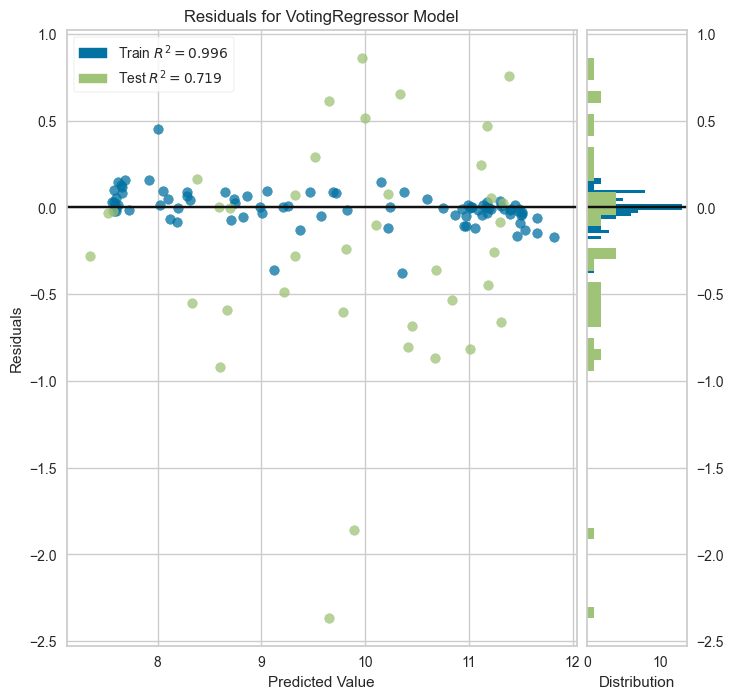

In [ ]:
# Mostrar gráficos del mejor modelo con un tamaño de 8x8
print("\nGenerando gráficos de diagnóstico para el modelo final...")

# Gráfico de Residuos
plt.figure(figsize=(8, 8))
ax1 = plt.gca()
experiment.plot_model(tuned_best_automl, plot='residuals', plot_kwargs={'ax': ax1})


#### Gráfico de Error de Predicción
Este gráfico compara los valores reales (y) con los valores predichos por el modelo (ŷ).

Interpretación: Los puntos se agrupan alrededor de la línea punteada "identidad", que representa una predicción perfecta. La línea de "mejor ajuste" (best fit) sigue de cerca a la línea de identidad, lo que es una buena señal.

R² (0.696): En el conjunto de prueba, el modelo alcanza un R² de 0.696. Esto es una mejora significativa respecto al R² de ~0.62 obtenido en la validación cruzada y sugiere que el modelo finalizado generaliza bien (Statistics by Jim, s. f.).


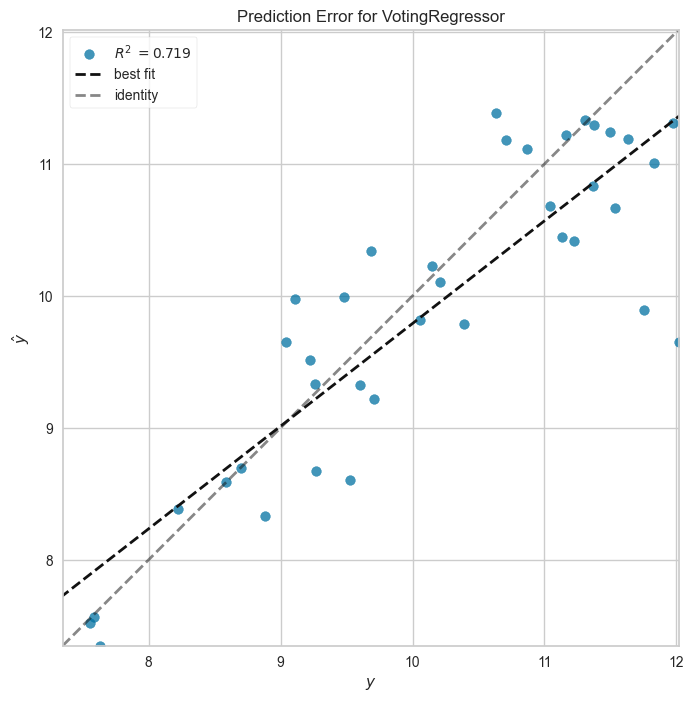

In [ ]:
# Gráfico de Errores de Predicción
plt.figure(figsize=(8, 8))
ax2 = plt.gca()
experiment.plot_model(tuned_best_automl, plot='error', plot_kwargs={'ax': ax2})


#### Curva de Aprendizaje
La curva de aprendizaje muestra cómo mejora el rendimiento del modelo a medida que se le proporcionan más datos de entrenamiento.

Training Score (Azul): El puntaje de entrenamiento es casi perfecto (cercano a 1.0) desde el principio, eso indica que el modelo tiene la capacidad de ajustarse a los datos que ve.

Cross Validation Score (Verde): El puntaje de validación cruzada aumenta a medida que se agregan más datos, comenzando en ~0.4 y estabilizándose alrededor de ~0.6.

Conclusión: La brecha (gap) entre la curva de entrenamiento y la de validación sugiere que el modelo tiene una varianza alta (sobreajuste). Aunque su rendimiento es bueno, podría beneficiarse de más datos (si los hubiera) de entrenamiento para reducir esta brecha y mejorar aún más la capacidad de generalización.


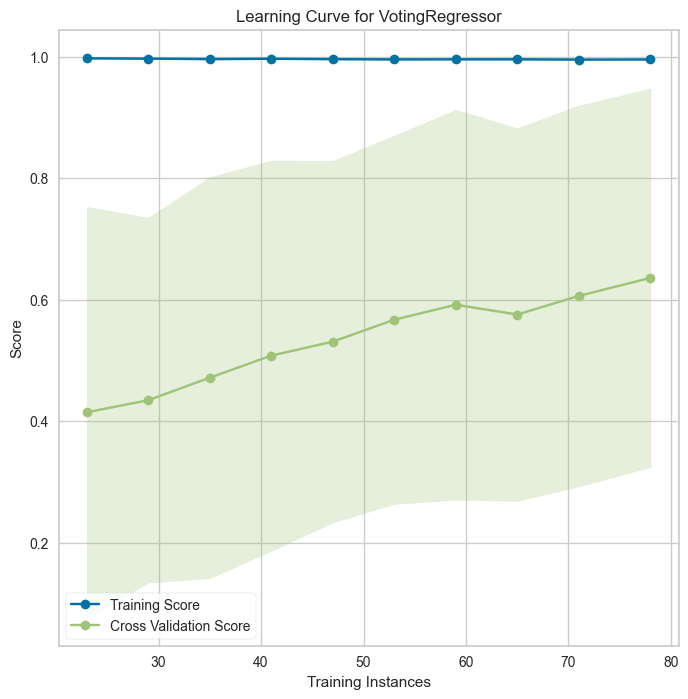

In [ ]:
# Gráfico de Errores de aprendizaje
plt.figure(figsize=(8, 8))
ax3 = plt.gca()
experiment.plot_model(tuned_best_automl, plot='learning', plot_kwargs={'ax': ax3})

#### Importancia de las Características (Feature Importance)
Estos gráficos muestran qué descriptores moleculares fueron más influyentes para las predicciones del modelo, al ser una mezcla de modelos se presentan los 3 graficos para cada modelo, en este caso, no todos los modelos dieron la misma importancia a todas las características.

Interpretación: Los descriptores más importantes varían entre los modelos base, pero se observan patrones:

Autocorrelación de Moran (Moran_...): Descriptores como Moran_BEGF750101_lag2 y Moran_ARGP820101_lag1 aparecen consistentemente como muy importantes. Estos miden la correlación de propiedades fisicoquímicas entre aminoácidos a diferentes distancias ("lags"), sugiriendo que la distribución espacial de estas propiedades es clave.

Composición de Aminoácidos (PAAC_ y APAAC_): Indican que la presencia de ciertos aminoácidos (como Isoleucina I o Serina S) es relevante.

Propiedades Fisicoquímicas (CTDC_, CTDD_): Descriptores relacionados con la hidrofobicidad, la polarizabilidad y el acceso al solvente son consistentemente importantes. Esto tiene mucho sentido biológico, ya que estas propiedades dictan cómo el péptido interactúa con su entorno acuoso y con el receptor (Feature importance — Scikit-learn, s. f.; Gerstorfer et al., 2023).


Gráfico de importancia de características para el modelo <catboost.core.CatBoostRegressor object at 0x0000022AC81D2840>...


<Figure size 800x800 with 0 Axes>

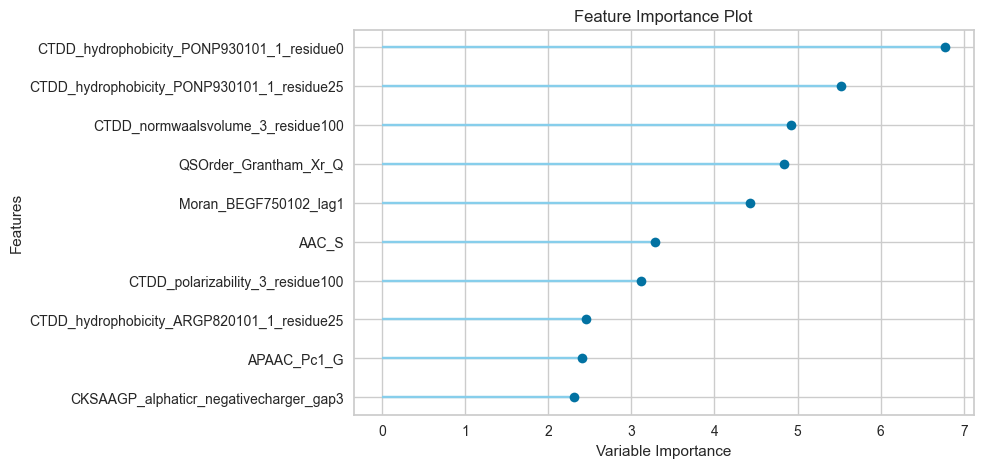

Gráfico de importancia de características para el modelo ExtraTreesRegressor(criterion='absolute_error', max_depth=5,
                    max_features=0.567711756337121,
                    min_impurity_decrease=0.005297055476899181,
                    min_samples_leaf=2, n_estimators=155, n_jobs=-1,
                    random_state=132400)...


<Figure size 800x800 with 0 Axes>

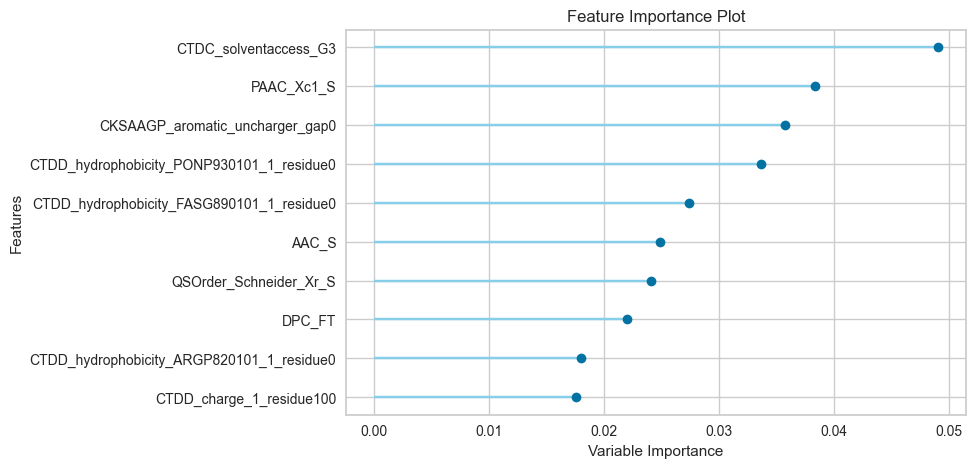

Gráfico de importancia de características para el modelo HuberRegressor(alpha=0.987530237988201, epsilon=1.5704959650312693)...


<Figure size 800x800 with 0 Axes>

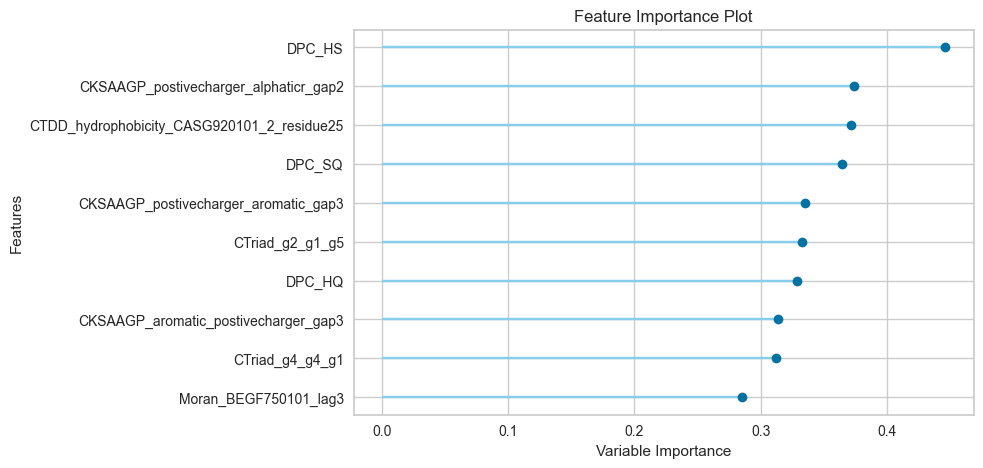

In [ ]:
# Gráfico de Importancia de Características este gráfico puede tardar un poco más en generarse y se es individual por modelo del ensamble

# graficamos la importancia de características del cada modelo del ensamble
for i, model in enumerate(tuned_best_3):
    plt.figure(figsize=(8, 8))
    #ax = plt.gca()
    print(f"Gráfico de importancia de características para el modelo {model}...")
    experiment.plot_model(model, plot='feature', plot_kwargs={'ax': ax})
    #plt.title(f'Importancia de Características - Modelo {i+1}')
    #plt.show()



### Finalizar el experimento
Por ultimo, entrenamos el mejor modelo con todos los datos disponibles (entrenamiento y prueba) para tener el modelo final listo para hacer predicciones.

In [ ]:
# Finalizar el modelo (entrenar con todos los datos)
print("\nFinalizando el modelo...")
final_model = experiment.finalize_model(tuned_best_automl)


Finalizando el modelo...


### Guardado de los modelos y el contexto del experimento
Guardamos el estado completo del experimento, incluyendo todos los modelos y transformaciones, para poder cargarlo en el futuro sin necesidad de re-entrenar.

In [ ]:
# Guardar el mejor modelo obtenido
print("\nGuardando el mejor modelo final...")
save_info = experiment.save_model(tuned_best_automl, ruta_mejor_modelo)
if save_info is not None:
    print(f"Mejor modelo final guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el mejor modelo final.")

# Guardar modelo final (Entrenado con todos los datos)
print("\nGuardando el mejor modelo final...")
save_info = experiment.save_model(tuned_best_automl, ruta_mejor_modelo_final)
if save_info is not None:
    print(f"Mejor modelo final guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el mejor modelo final.")    

# Guardar el experimento completo
print("\nGuardando el estado del experimento...")
save_info = experiment.save_experiment(ruta_experimento)
if save_info is not None:
    print(f"Estado del experimento guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el estado del experimento.")    


Guardando el mejor modelo final...
Transformation Pipeline and Model Successfully Saved
Mejor modelo final guardado en: ..\models\pycaret\modelos_GLP1_no_pca\mejor_modelo.pkl

Guardando el mejor modelo final...
Transformation Pipeline and Model Successfully Saved
Mejor modelo final guardado en: ..\models\pycaret\modelos_GLP1_no_pca\mejor_modelo_final.pkl

Guardando el estado del experimento...
No se pudo guardar el estado del experimento.


### Predicción sobre Datos Desconocidos
Utilizamos nuestro mejor modelo finalizado para predecir la actividad (pEC50) de los péptidos del conjunto de datos df_desconocidos. Los resultados se guardan en un archivo CSV.

In [ ]:
# Realizar predicciones sobre el dataframe de desconocidos
print(f"Realizando predicciones sobre {len(df_desconocidos)} péptidos desconocidos...")
predicciones_desconocidos = experiment.predict_model(final_model, data=df_desconocidos)
predicciones_conocidos = experiment.predict_model(tuned_best_automl, data=df_entrenamiento)

# Renombrar la columna de predicción para mayor claridad
predicciones_desconocidos.rename(columns={'prediction_label': 'pEC50_predicho'}, inplace=True)
predicciones_conocidos.rename(columns={'prediction_label': 'pEC50_predicho'}, inplace=True)

# Guardar las predicciones en un archivo CSV
predicciones_desconocidos.to_csv(ruta_resultados_prediccion)

print(f"\nPredicciones guardadas en: {ruta_resultados_prediccion}")


Realizando predicciones sobre 225 péptidos desconocidos...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1956,0.1500,0.3873,0.9315,0.0341,0.0192



Predicciones guardadas en: ..\data\Predicciones_Peptidos_GLP1.csv


In [ ]:
print("Muestra de las predicciones:")
display(predicciones_conocidos.head(3))

Muestra de las predicciones:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,EC50_T2,EC50_LOG_T2,pEC50,pEC50_predicho
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep1,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.0,0.033333,0.066667,...,-0.182783,0.054222,0.190428,-0.142437,0.090372,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,563.0,-9.25,9.249492,9.256478
seq_pep2,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.0,0.033333,0.066667,...,-0.316149,0.170202,0.157133,-0.144228,0.115217,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,552.0,-9.26,9.258060,9.328444
seq_pep3,0.034483,0.0,0.103448,0.068966,0.068966,0.034483,0.034483,0.0,0.034483,0.068966,...,-0.250582,0.181550,0.098041,-0.203722,0.127012,HSQGTFTSDYSKYLDSRRAEDFVQWLENT,252.0,-9.60,9.598599,9.321180


In [ ]:
print("Muestra de las predicciones:")
display(predicciones_desconocidos.head(10))

Muestra de las predicciones:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,NMBroto_BEGF750103_lag2,NMBroto_BEGF750103_lag3,NMBroto_BHAR880101_lag1,NMBroto_BHAR880101_lag2,NMBroto_BHAR880101_lag3,sequence,EC50_T2,EC50_LOG_T2,pEC50,pEC50_predicho
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep1,0.033333,0.00,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,0.066667,...,-0.182783,0.054222,0.190428,-0.142437,0.090372,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE,563.000000,-9.25,9.249492,9.256478
seq_pep2,0.033333,0.00,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,0.066667,...,-0.316149,0.170202,0.157133,-0.144228,0.115217,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE,552.000000,-9.26,9.258060,9.328444
seq_pep3,0.034483,0.00,0.103448,0.068966,0.068966,0.034483,0.034483,0.000000,0.034483,0.068966,...,-0.250582,0.181550,0.098041,-0.203722,0.127012,HSQGTFTSDYSKYLDSRRAEDFVQWLENT,252.000000,-9.60,9.598599,9.321180
seq_pep4,0.055556,0.00,0.083333,0.027778,0.055556,0.166667,0.027778,0.000000,0.027778,0.055556,...,-0.097965,0.052838,0.377701,0.150231,0.286987,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG,6.030000,-11.22,11.219683,11.209304
seq_pep5,0.066667,0.00,0.100000,0.066667,0.066667,0.066667,0.033333,0.000000,0.033333,0.066667,...,-0.190213,0.020097,0.069381,-0.184796,0.222087,HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG,238.000000,-9.62,9.623423,9.573532
seq_pep6,0.066667,0.00,0.100000,0.100000,0.066667,0.033333,0.033333,0.000000,0.033333,0.066667,...,-0.061772,0.092750,0.051983,-0.166879,0.203400,HSQGTFTSDYSKYLDSRRAQDFVQWLEAEE,1610.000000,-8.79,8.793174,8.857814
seq_pep7,0.068966,0.00,0.034483,0.137931,0.068966,0.068966,0.000000,0.034483,0.034483,0.137931,...,0.194179,0.178745,0.100220,-0.256994,0.033664,YSQGTFTSDYSKYLEEEAVRLFIEWLLAG,1.060000,-11.97,11.974694,11.312422
seq_pep8,0.166667,0.00,0.033333,0.100000,0.066667,0.100000,0.000000,0.066667,0.066667,0.066667,...,-0.150722,0.097377,0.235831,-0.273023,-0.191603,YAEGTFTSDYSIALEGQAAKEFIAWLVKGR,58.200001,-10.24,10.235077,10.239463
seq_pep9,0.033333,0.00,0.033333,0.166667,0.066667,0.066667,0.000000,0.033333,0.066667,0.133333,...,0.072391,0.242408,0.187622,-0.312484,-0.075726,YSEGTFTSDYSKLLEEEAVRLFIEWLVKGP,11.300000,-10.95,10.946921,10.937880


### Analisis de la efectividad usando PCA

Para evaluar la efectividad del modelo, podemos utilizar PCA para reducir la dimensionalidad de los datos y visualizar cómo se distribuyen los péptidos conocidos y desconocidos en el espacio de características. Para ello, aplicamos PCA a ambos conjuntos de datos y graficamos los resultados en 3D.   


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


pca = PCA(n_components=3)
principal_components_conocidos = pca.fit_transform( scaler.fit_transform(predicciones_conocidos.drop(columns=['pEC50', 'pEC50_predicho','sequence'])))
pca_df = pd.DataFrame(data=principal_components_conocidos, columns=['PC1', 'PC2', 'PC3'])
# Unir los componentes principales con la columna pEC50 usando el índice
pca_df = pca_df.set_index(predicciones_conocidos.index)
df_pca_conocidos = pd.concat([pca_df, predicciones_conocidos['pEC50']], axis=1)
#pca = PCA(n_components=2)

#pca = PCA(n_components=2)



In [ ]:
pca = PCA(n_components=3)
principal_components_desconocidos = pca.fit_transform(scaler.fit_transform(predicciones_desconocidos.drop(columns=['pEC50_predicho','sequence'])))
pca_df_desconocidos = pd.DataFrame(data=principal_components_desconocidos, columns=['PC1', 'PC2', 'PC3'])

# Unir los componentes principales con la columna pEC50 usando el índice
pca_df_desconocidos = pca_df_desconocidos.set_index(predicciones_desconocidos.index)
df_pca_desconocidos = pd.concat([pca_df_desconocidos, predicciones_desconocidos['pEC50_predicho']], axis=1)
#pca = PCA(n_components=2)

#pca = PCA(n_components=2)

In [ ]:
df_pca_conocidos

,PC1,PC2,PC3,pEC50
ID,,,,
seq_pep1,0.053831,21.065056,-1.211756,9.249492
seq_pep2,0.013833,20.318600,-1.887282,9.258060
seq_pep3,0.746500,21.820871,-2.269439,9.598599
seq_pep4,12.338152,5.551005,-12.636959,11.219683
seq_pep5,0.363610,19.194775,-2.866980,9.623423
...,...,...,...,...
seq_pep121,-9.935054,-1.961855,0.045398,11.016825
seq_pep122,-10.124287,-2.621048,0.930262,11.100180
seq_pep123,-6.689830,-2.840514,-1.193209,7.530178


In [ ]:
df_pca_desconocidos

,PC1,PC2,PC3,pEC50_predicho
ID,,,,
AF-A0A060VXS0-F1,-5.898613,-6.585402,0.636288,8.845445
AF-A0A060VY52-F1,-6.809289,-7.727774,0.647378,9.006936
AF-A0A060WDT4-F1,-8.412887,-8.252403,0.820018,9.608928
AF-A0A087VEU7-F1,-7.453612,-4.645208,15.098798,9.228744
AF-A0A087XPV4-F1,-6.700803,-7.893563,-10.603468,9.927053
...,...,...,...,...
XP_027996892.1,-5.206195,1.758922,10.536369,10.901939
XP_028292477.1,-8.147129,-8.321735,-3.149271,9.253559
XP_029460758.1,-5.298041,-1.813226,9.782979,9.277426


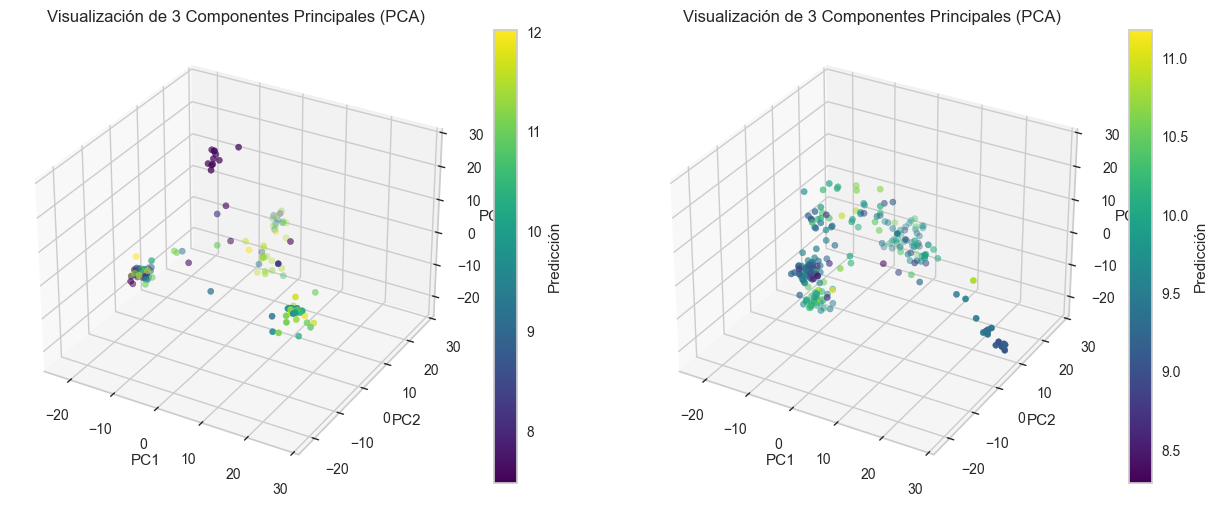

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura con dos subplots horizontales
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('PCA 3D con Datos Conocidos')
ax2.set_title('PCA 3D con Datos Desconocidos')

plot_pca_3d(
    df_pca_conocidos,
    pc_x='PC1',
    pc_y='PC2',
    pc_z='PC3',
    color_by='pEC50',
    label='Predicción',
    xlim=(-25, 30),
    ylim=(-25, 30),
    zlim=(-25, 30),
    ax=ax1,
)

# Segundo subplot
plot_pca_3d(
    df_pca_desconocidos,
    pc_x='PC1',
    pc_y='PC2',
    pc_z='PC3',
    color_by='pEC50_predicho',
    label='Predicción',
    xlim=(-25, 30),
    ylim=(-25, 30),
    zlim=(-25, 30),
    ax=ax2,
)


# Mostrar ambos
plt.tight_layout()
plt.show()


## Conclusiones

#### Rendimiento y Complejidad del Modelo
El análisis comparativo demostró que los modelos de ensamble basados en árboles de decisión (CatBoost, Extra Trees, LightGBM) superaron consistentemente a los modelos lineales. Esto sugiere que las relaciones entre los descriptores moleculares y la actividad biológica son muy complejas y no lineales.

El modelo ganador fue un ensamble Blending (VotingRegressor), que logró un rendimiento promedio de R² ≈ 0.62 durante la validación cruzada y un R² final de 0.696 en el conjunto de prueba. Este valor se considera aceptable y útil en el campo de los estudios QSAR (Relación Cuantitativa Estructura-Actividad) para bioquímica, donde un R² superior a 0.6 es indicativo de un modelo con capacidad predictiva confiable. El modelo es capaz de explicar casi el 70% de la variabilidad en la actividad de los péptidos, lo cual es un resultado razonable, especialmente considerando el tamaño limitado del conjunto de datos de entrenamiento de solo 125 Peptidos.

 #### Impacto de la Reducción de Dimensionalidad (PCA)
Al comparar las ejecuciones con y sin Análisis de Componentes Principales (PCA), se observó que reducir la dimensionalidad del problema disminuyó la calidad de las predicciones. Aunque el PCA puede ayudar a crear modelos más simples y estables, en este caso, llevo una pérdida de información contenida en las no linealidades de los descriptores originales, debido al que no se poseen mas datos para el entrenamiento la capacidad predictiva depende aun mas de las caracteristicas de los péptidos para hacer el análisis.

* Sin PCA: Se obtuvo mayor precisión y una mejor captura de las relaciones complejas, a costa de una mayor complejidad computacional.

* Con PCA: Se generaron modelos más simples, pero con un poder predictivo inferior.

La conclusión es que, para este conjunto de datos, el PCA no es beneficioso si el objetivo principal es maximizar la precisión.

#### Modelos Ensambles
La estrategia de combinar los tres mejores modelos ajustados a través de un ensamble de tipo Blending resultó positiva. El modelo final (VotingRegressor) tuvo una mejora marginal pero significativa en el R² promedio en comparación con el mejor modelo individual. Combinar las "opiniones" de múltiples modelos complejos puede mitigar los errores individuales y producir un predictor más robusto y generalizable.

 ### Consideraciones sobre la Métrica del Error y la Escala Logarítmica usada
En este caso nusetros modelos fueron entrenado para predecir pEC50, que es una escala logarítmica del la variable EC 50 obtenida experimentalmente. Un error promedio (MAE) de ~0.65 en esta escala puede no parecer grande, pero al convertirlo de nuevo a la escala original de EC50, el error puede ser considerable. Por ejemplo, una diferencia de 1 unidad en la escala logarítmica representa una diferencia de 10 veces en la concentración. Esto significa que, si bien el modelo es excelente para clasificar péptidos (activo vs. inactivo) y ordenar su potencia relativa, las predicciones puntusobreales de EC50 tendran un error muy grande. Sin embargo, no es posible entrenar directamente el modelo usando la variable sin transformar debido al la disparidad de valores y la escala de los datos.

## Referencias

* Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow (3rd ed.). O’Reilly Media.
* Han, J., Kamber, M., & Pei, J. (2022). Data Mining: Concepts and Techniques (4th ed.). Morgan Kaufmann.
* Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
* GraphPad. (s. f.). Fitting the pEC50 – FAQ 1419. Recuperado de https://www.graphpad.com/support/faq/fitting-the-pec50/
* Motulsky, H. J. (2025). Analyzing lognormal data: A nonmathematical practical guide. Pharmacological Reviews. Recuperado de https://pharmrev.aspetjournals.org/article/S0031-6997%2825%2907457-5/fulltext
* De Myttenaere, A., Le Grand, B., & Rossi, F. (2015). Using the Mean Absolute Percentage Error for Regression Models. arXiv. https://arxiv.org/abs/1506.04176
* Chai, T., & Draxler, R. R. (2014). Root mean square error (RMSE) or mean absolute error (MAE)? – Arguments against avoiding RMSE in the literature. Geoscientific Model Development, 7(3), 1247–1250. https://doi.org/10.5194/gmd-7-1247-2014
* DooinnKim. (s. f.). Regression plots explained (Actual vs Predicted, Residual, and more). Medium. Recuperado de https://medium.com/@dooinnkim/regression-plots-explained-actual-vs-predicted-residual-and-more
* Gerstorfer, D., Haug, S., & Müller, A. C. (2023). A critical look at interpretability and feature importance in machine learning. Frontiers in Artificial Intelligence, 6, 1170563. https://doi.org/10.3389/frai.2023.1170563
* Qualtrics. (s. f.). Residual plots and model assumptions in regression. Recuperado de https://www.qualtrics.com/experience-management/research/residual-plot/
* Scikit-learn developers. (s. f.). Feature importance and model interpretation — Scikit-learn documentation. Recuperado de https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* Statistics by Jim. (s. f.). Understanding R-squared: Definition, interpretation and limitations. Recuperado de https://statisticsbyjim.com/regression/interpret-r-squared-regression/
* Srinivasan, B. (2025). Quantitation and Error Measurements in Dose–Response. Journal of Medicinal Chemistry. Recuperado de https://pubs.acs.org/doi/full/10.1021/acs.jmedchem.5c00131
* van Tilborg, D., et al. (2022). Exposing the Limitations of Molecular Machine Learning. PMC. Recuperado de https://pmc.ncbi.nlm.nih.gov/articles/PMC9749029/
* Qin, L. T., et al. (2024). A comprehensive machine learning-based models for … Environmental Research. (artículo donde se usaron valores de pEC₅₀ como entrada). 
* STATCON. (s. f.). Dose-Response Curves — pEC₅₀: definición y uso. Recuperado de https://www.statcon.de/en/Knowledge/What-is-Life-Science/Dose-Response-Curves/
* PyCaret 3.0 | Docs. (s. f.). Docs. https://pycaret.gitbook.io/
* https://pycaret.gitbook.io/docs/get-started/functions/optimize#method-bagging
* Yellowbrick: Machine Learning Visualization — Yellowbrick v1.5 documentation. (s. f.). https://www.scikit-yb.org/en/latest/


